# 决策树与随机森林
## 分类问题
数据集：Titanic乘客在灾难中是否存活

### 数据清洗

In [4]:
# 导入第三方模块
import pandas as pd
%config ZMQInteractiveShell.ast_node_interactivity='all'   # nootbook使用

In [6]:
# 读入数据
Titanic = pd.read_csv(r'Titanic.csv')
Titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# 删除无意义的变量，并检查剩余自字是否含有缺失值
Titanic.drop(['PassengerId','Name','Ticket','Cabin'], axis = 1, inplace = True)
Titanic.head()
Titanic.info()
any(Titanic.duplicated())
Titanic.isnull().sum(axis = 0)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


True

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

1. Pclass为船舱等级，虽然为数字，但仍需要做哑变量处理，因为他是类别变量；Sex和Embarked均为离散的字符型变量，建模前要进行编码，如因子化处理、one-hot、哑变量处理等。
2. 分别对Age和Embarked使用均值填充法和众数填充法。由于Age变量的缺失个数比较多，故不直接用该字段的均值填充缺失值，而是按照性别对客户的缺失年龄分组填充。

In [10]:
# 对Sex分组，用各组乘客的平均年龄填充各组中的缺失年龄
fillna_Titanic = []
for i in Titanic.Sex.unique():
    update = Titanic.loc[Titanic.Sex == i,].fillna(value = {'Age': Titanic.Age[Titanic.Sex == i].mean()}, inplace = False)
    fillna_Titanic.append(update)
Titanic = pd.concat(fillna_Titanic)   # 按照行合并，即纵向合并

Titanic.head()
Titanic.tail()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
4,0,3,male,35.000000,0,0,8.0500,S
5,0,3,male,30.726645,0,0,8.4583,Q
6,0,1,male,54.000000,0,0,51.8625,S
7,0,3,male,2.000000,3,1,21.0750,S


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
880,1,2,female,25.000000,0,1,26.0000,S
882,0,3,female,22.000000,0,0,10.5167,S
885,0,3,female,39.000000,0,5,29.1250,Q
887,1,1,female,19.000000,0,0,30.0000,S
888,0,3,female,27.915709,1,2,23.4500,S


In [16]:
# 使用Embarked变量的众数填充缺失值
# mode()
Titanic.fillna(value = {'Embarked':Titanic.Embarked.mode()[0]}, inplace=True)
Titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
4,0,3,male,35.000000,0,0,8.0500,S
5,0,3,male,30.726645,0,0,8.4583,Q
6,0,1,male,54.000000,0,0,51.8625,S
7,0,3,male,2.000000,3,1,21.0750,S


In [17]:
# 将数值型的Pclass转换为类别型，否则无法对其哑变量处理
Titanic.Pclass = Titanic.Pclass.astype('category')
Titanic.head()
Titanic.dtypes

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
4,0,3,male,35.000000,0,0,8.0500,S
5,0,3,male,30.726645,0,0,8.4583,Q
6,0,1,male,54.000000,0,0,51.8625,S
7,0,3,male,2.000000,3,1,21.0750,S


Survived       int64
Pclass      category
Sex           object
Age          float64
SibSp          int64
Parch          int64
Fare         float64
Embarked      object
dtype: object

In [18]:
Titanic.head()
# 哑变量处理
dummy = pd.get_dummies(Titanic[['Sex','Embarked','Pclass']])
dummy.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
4,0,3,male,35.000000,0,0,8.0500,S
5,0,3,male,30.726645,0,0,8.4583,Q
6,0,1,male,54.000000,0,0,51.8625,S
7,0,3,male,2.000000,3,1,21.0750,S


,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,1,0,0,1,0,0,1
4,0,1,0,0,1,0,0,1
5,0,1,0,1,0,0,0,1
6,0,1,0,0,1,1,0,0
7,0,1,0,0,1,0,0,1


In [19]:
# 水平合并Titanic数据集和哑变量的数据集
Titanic = pd.concat([Titanic,dummy], axis = 1)

# 删除原始的Sex、Embarked和Pclass变量
Titanic.drop(['Sex','Embarked','Pclass'], inplace=True, axis = 1)
Titanic.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,22.000000,1,0,7.2500,0,1,0,0,1,0,0,1
4,0,35.000000,0,0,8.0500,0,1,0,0,1,0,0,1
5,0,30.726645,0,0,8.4583,0,1,0,1,0,0,0,1
6,0,54.000000,0,0,51.8625,0,1,0,0,1,1,0,0
7,0,2.000000,3,1,21.0750,0,1,0,0,1,0,0,1


哑变量是表中右边8个变量，由于决策树不对多重共线性敏感，故无需删除某类哑变量的一个（如sex_female）,而且二分支决策树也会对离散变量中的不同值做组合运算。

### 构建决策树模型

In [23]:
# 导入第三方包
from sklearn import model_selection
# 取出所有自变量名称
predictors = Titanic.columns[1:]
# 将数据集拆分为训练集和测试集，且测试集的比例为25%
X_train, X_test, y_train, y_test = model_selection.train_test_split(Titanic[predictors], 
                                                                    Titanic.Survived, 
                                                                    test_size = 0.25, 
                                                                    random_state = 1234)

为了防止构建的决策树产生过拟合，需要对决策树进行预剪枝，如：限制树生长的最大深度、设置决策树的中间节点能够继续分支的最小样本量以及叶节点的最小样本量。

In [25]:
# 导入第三方模块
from sklearn.model_selection import GridSearchCV
from sklearn import tree

# 预设各参数的不同选项值
max_depth = [2,3,4,5,6]
min_samples_split = [2,4,6,8]
min_samples_leaf = [2,4,8,10,12]

# 将各参数值以字典形式组织起来
parameters = {'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'min_samples_leaf':min_samples_leaf}

# 网格搜索法，测试不同的参数值
grid_dtcateg = GridSearchCV(estimator = tree.DecisionTreeClassifier(),
                            param_grid = parameters, 
                            cv=10)  # 10重交叉验证

# 模型拟合
grid_dtcateg.fit(X_train, y_train)

# 返回最佳组合的参数值
grid_dtcateg.best_params_

D:\software\anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 4, 5, 6], 'min_samples_split': [2, 4, 6, 8], 'min_samples_leaf': [2, 4, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

{'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}

根据经验，如果数据量较小时，树的最大深度可设置为10以内，反之需设置较大的树深度，如20左右。接下来用这个参数构建分类决策树。

In [26]:
# 导入第三方模块
from sklearn import metrics
# 构建分类决策树
CART_Class = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf = 4, min_samples_split=2)
# 模型拟合
decision_tree = CART_Class.fit(X_train, y_train)
# 模型在测试集上的预测
pred = CART_Class.predict(X_test)
# 模型的准确率
print('模型在训练集的预测准确率：\n',metrics.accuracy_score(y_train, CART_Class.predict(X_train)))
print('模型在测试集的预测准确率：\n',metrics.accuracy_score(y_test, pred))
print('模型在测试集的正例覆盖率（查全率）：\n',metrics.recall_score(y_test, pred))
print('模型在测试集的查准率：\n',metrics.precision_score(y_test, pred))
print('模型在测试集的负例覆盖率：\n',metrics.recall_score(y_test, pred, pos_label=0))

# 更好的拟合了负例的特性

模型在训练集的预测准确率：
 0.8038922155688623
模型在测试集的预测准确率：
 0.8295964125560538
模型在测试集的正例覆盖率（查全率）：
 0.651685393258427
模型在测试集的查准率：
 0.8923076923076924
模型在测试集的负例覆盖率：
 0.9477611940298507


### 决策树模型评估

array([[127,   7],
       [ 31,  58]], dtype=int64)

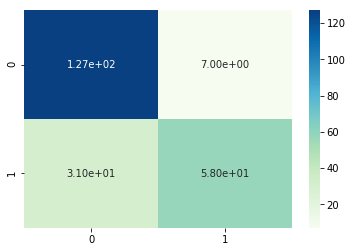

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_test,pred,labels=[0,1])
cm
sns.heatmap(cm,annot=True,fmt='.2e',cmap='GnBu')

Text(0.5, 0.3, 'ROC curve (area = 0.85)')

Text(0.5, 0, '1-Specificity')

Text(0, 0.5, 'Sensitivity')

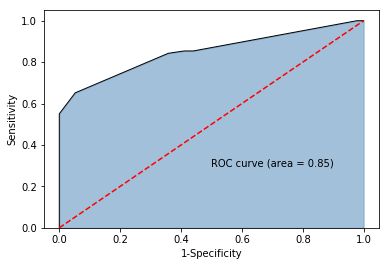

In [84]:
# 导入第三方包
import matplotlib.pyplot as plt

y_score = CART_Class.predict_proba(X_test)[:,1]  # 类别为1的概率得分
fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
# fpr  =  假正例/实际反例
# tpr  =  真正例/实际正例
# threshold

# 计算AUC的值
roc_auc = metrics.auc(fpr,tpr)

# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
# 显示图形
plt.show()

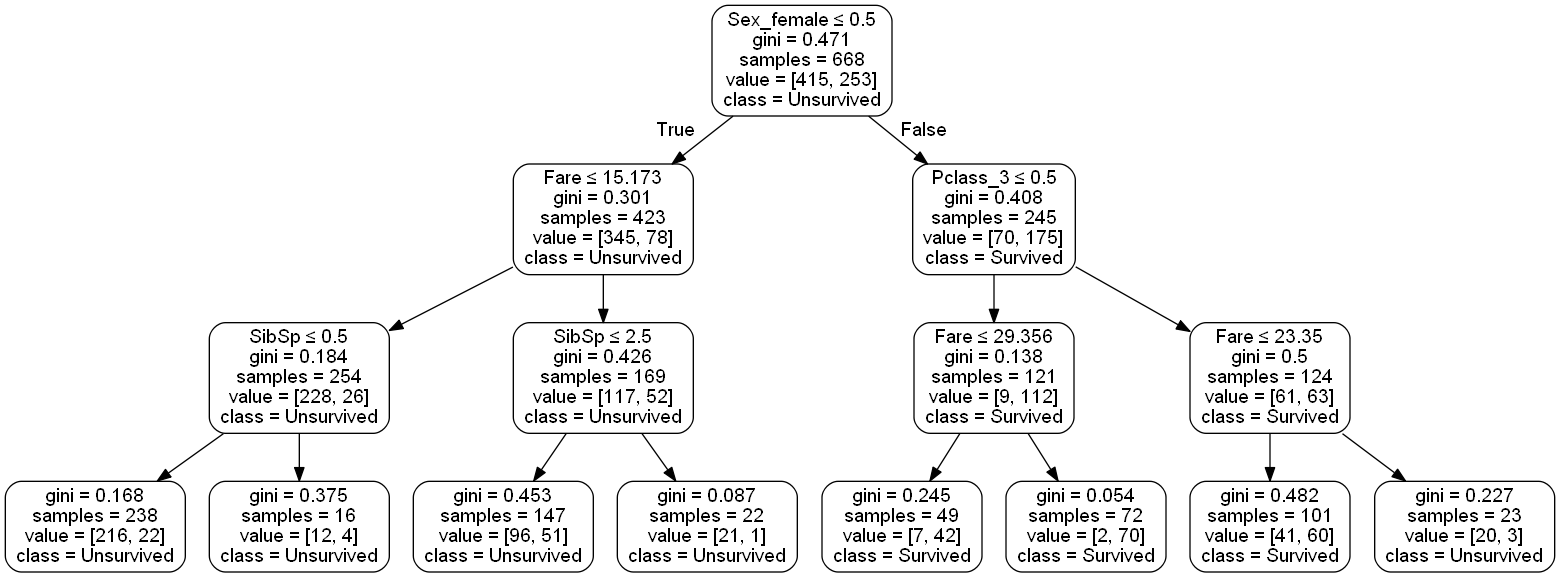

In [78]:
# 需要在电脑中安装Graphviz
# https://graphviz.gitlab.io/_pages/Download/Download_windows.html
# 然后将解压文件中的bin设置到环境变量中
# 导入第三方模块

# 不过我手工在环境变量中添加了bin路径不行，运行下边这个语句
import os
os.environ["PATH"] += os.pathsep + 'D:/software/graphviz-2.38/release/bin/'  #注意修改你的路径


from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO

# 绘制决策树
dot_data = StringIO()
export_graphviz(
    decision_tree,
    out_file=dot_data,  
    feature_names=predictors,
    class_names=['Unsurvived','Survived'],  
#     filled=True,
    rounded=True,  
    special_characters=True
)
# 决策树展现
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png()) 


### 构建随机森林模型
避免单颗树出现过拟合；提高模型的预测准确率

In [79]:
# 导入第三方包
from sklearn import ensemble
# 构建随机森林
# n_estimators 决策树个数
RF_class = ensemble.RandomForestClassifier(n_estimators=200, 
                                           random_state=1234)
# 随机森林的拟合
RF_class.fit(X_train, y_train)
# 模型在测试集上的预测
RFclass_pred = RF_class.predict(X_test)
# 模型的准确率
print('模型在测试集的预测准确率：\n',metrics.accuracy_score(y_test, RFclass_pred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

模型在测试集的预测准确率：
 0.852017937219731


Text(0.5, 0.3, 'ROC curve (area = 0.88)')

Text(0.5, 0, '1-Specificity')

Text(0, 0.5, 'Sensitivity')

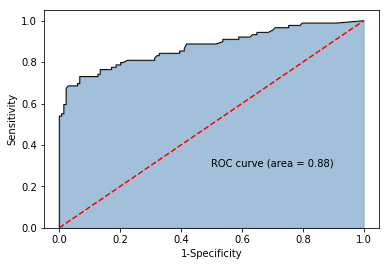

In [82]:
# 计算绘图数据
y_score = RF_class.predict_proba(X_test)[:,1]
fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)  # 注意第二个参数是正样本的概率
roc_auc = metrics.auc(fpr,tpr)
# 绘图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
plt.plot(fpr, tpr, color='black', lw = 1)
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.show()

采用随机森林模型，测试集的准确率和auc面积都比决策树要高，最后利用理想的随机森林算法挑选出影响乘客是否幸存的重要因素。

array([0.2613552 , 0.06009362, 0.04101648, 0.25117767, 0.13481804,
       0.12816612, 0.01400895, 0.00867103, 0.01692769, 0.02100093,
       0.01442442, 0.04833985])

Age           0.261355
SibSp         0.060094
Parch         0.041016
Fare          0.251178
Sex_female    0.134818
Sex_male      0.128166
Embarked_C    0.014009
Embarked_Q    0.008671
Embarked_S    0.016928
Pclass_1      0.021001
Pclass_2      0.014424
Pclass_3      0.048340
dtype: float64

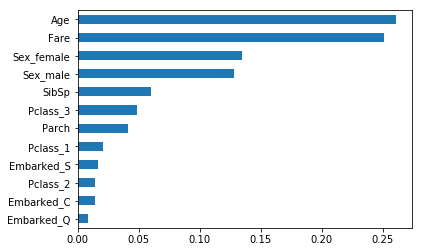

In [87]:
# 变量的重要性程度值
importance = RF_class.feature_importances_
importance

# 构建含序列用于绘图
Impt_Series = pd.Series(importance, index = X_train.columns)
Impt_Series

# 对序列排序绘图
Impt_Series.sort_values(ascending = True).plot('barh')
plt.show()

## 预测问题

In [88]:
# 读入数据
NHANES = pd.read_excel(r'.\NHANES.xlsx')
NHANES.head()
print(NHANES.shape)
# 最后一列是因变量，连续值

,age_months,sex,black,BMI,HDL,CKD_stage,S_Creat,cal_creat,meals_not_home,CKD_epi_eGFR
0,472,1,0,30.22,35,0,1.0,1.0,2,94.388481
1,283,1,1,29.98,43,0,1.1,1.1,1,109.086423
2,1011,2,0,24.62,51,0,0.8,0.8,1,67.700441
3,176,2,0,27.28,48,1,0.6,0.6,3,136.861679
4,534,1,0,33.84,37,0,0.9,0.9,2,103.510891


(28009, 10)


In [91]:
# 取出自变量名称
predictors = NHANES.columns[:-1]
# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = model_selection.train_test_split(NHANES[predictors], 
                                                                    NHANES.CKD_epi_eGFR, 
                                                                    test_size = 0.25, 
                                                                    random_state = 1234)

### 构建决策树模型

In [92]:
# 预设各参数的不同选项值
max_depth = [18,19,20,21,22]
min_samples_split = [2,4,6,8]
min_samples_leaf = [2,4,8]
parameters = {'max_depth':max_depth, 
              'min_samples_split':min_samples_split, 
              'min_samples_leaf':min_samples_leaf}
# 网格搜索法，测试不同的参数值
grid_dtreg = GridSearchCV(estimator = tree.DecisionTreeRegressor(), 
                          param_grid = parameters, 
                          cv=10)
# 模型拟合
grid_dtreg.fit(X_train, y_train)
# 返回最佳组合的参数值
grid_dtreg.best_params_

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [18, 19, 20, 21, 22], 'min_samples_split': [2, 4, 6, 8], 'min_samples_leaf': [2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 4}

In [93]:
# 构建用于回归的决策树
CART_Reg = tree.DecisionTreeRegressor(max_depth = 20, min_samples_leaf = 2, min_samples_split = 4)
# 回归树拟合
CART_Reg.fit(X_train, y_train)
# 模型在测试集上的预测
pred = CART_Reg.predict(X_test)
# 计算衡量模型好坏的MSE值
metrics.mean_squared_error(y_test, pred)  
# 由于因变量是连续值，不能采用分类模型的准确率进行评估，采用MSE或者RMSE,这里采用MSE

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

1.8186564766815692

### 构建随机森林

In [94]:
# 构建用于回归的随机森林
RF = ensemble.RandomForestRegressor(n_estimators=200, random_state=1234)
# 随机森林拟合
RF.fit(X_train, y_train)
# 模型在测试集上的预测
RF_pred = RF.predict(X_test)
# 计算模型的MSE值
metrics.mean_squared_error(y_test, RF_pred)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=1234, verbose=0, warm_start=False)

0.8943765841580971

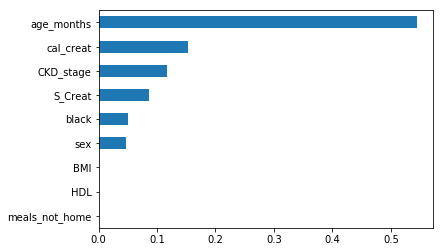

In [95]:
# 构建变量重要性的序列
importance = pd.Series(RF.feature_importances_, index = X_train.columns)
# 排序并绘图
importance.sort_values().plot('barh')
plt.show()